In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eg3dgen/ffhq512-128.pkl


In [2]:
!rm -rf /kaggle/working/*

In [3]:
!pip install mrcfile torch-summary
# we gotta decide which repo to use
!git clone https://github.com/Jaswar/dl-project 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 636.1 kB/s eta 0:00:00--:--
Cloning into 'dl-project'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 210 (delta 4), reused 22 (delta 4), pack-reused 188
Receiving objects: 100% (210/210), 2.11 MiB | 11.52 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [4]:
!cp -r /kaggle/working/dl-project/eg3d/torch_utils /kaggle/working
!cp -r /kaggle/working/dl-project/eg3d/dnnlib /kaggle/working
!cp -r /kaggle/working/dl-project/eg3d/training /kaggle/working

In [5]:
!mv /kaggle/working/dl-project /kaggle/working/dl_project # python modules dont accept kebab case

# Generate the images
The following line generates 4 images (seeds 0, 1, 2, 3) and outputs their depth shapes to the out directory located in '/kaggle/working/out'.

In [5]:
# !python eg3d/eg3d/gen_samples.py --outdir=out --trunc=0.7 --seeds=0-3 --shapes=True --network=../../kaggle/input/eg3dgen/ffhq512-128.pkl

In [6]:
import pickle
import torch
import PIL.Image
from tqdm import tqdm
from torchsummary import summary

from dl_project.eg3d.camera_utils import LookAtPoseSampler, FOV_to_intrinsics


with open('/kaggle/input/eg3dgen/ffhq512-128.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()

In [8]:
def create_image(
    seed,
    truncation_psi: float = 1.,
    truncation_cutoff: int = 14,
    fov_deg: float = 18.837,
    outdir: str = 'out',
):
    os.makedirs(outdir, exist_ok=True)
    
    device = torch.device('cuda')
    
    intrinsics = FOV_to_intrinsics(fov_deg, device=device)
    
    z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)
    
    angle_y = 0
    angle_p = -0.2
    
    cam_pivot = torch.tensor(G.rendering_kwargs.get('avg_camera_pivot', [0, 0, 0]), device=device)
    cam_radius = G.rendering_kwargs.get('avg_camera_radius', 2.7)
    cam2world_pose = LookAtPoseSampler.sample(np.pi/2 + angle_y, np.pi/2 + angle_p, cam_pivot, radius=cam_radius, device=device)
    conditioning_cam2world_pose = LookAtPoseSampler.sample(np.pi/2, np.pi/2, cam_pivot, radius=cam_radius, device=device)
    camera_params = torch.cat([cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)
    conditioning_params = torch.cat([conditioning_cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)

    ws = G.mapping(z, conditioning_params, truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff)
    img = G.synthesis(ws, camera_params)['image']

    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    img_dir = f'{outdir}/seed{seed:04d}.png'
    
    img_file = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')
    
    return z, img_file

def gen_image_from_z(
    z,
    truncation_psi: float = 1.,
    truncation_cutoff: int = 14,
    fov_deg: float = 18.837,
    outdir: str = 'out',
):
    angle_y = 0
    angle_p = -0.2
    device = torch.device('cuda')
    intrinsics = FOV_to_intrinsics(fov_deg, device=device)

    cam_pivot = torch.tensor(G.rendering_kwargs.get('avg_camera_pivot', [0, 0, 0]), device=device)
    cam_radius = G.rendering_kwargs.get('avg_camera_radius', 2.7)
    cam2world_pose = LookAtPoseSampler.sample(np.pi/2 + angle_y, np.pi/2 + angle_p, cam_pivot, radius=cam_radius, device=device)
    conditioning_cam2world_pose = LookAtPoseSampler.sample(np.pi/2, np.pi/2, cam_pivot, radius=cam_radius, device=device)
    camera_params = torch.cat([cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)
    conditioning_params = torch.cat([conditioning_cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)

    ws = G.mapping(z, conditioning_params, truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff)
    img = G.synthesis(ws, camera_params)['image']

    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    
    img_file = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')
    
    return img_file

def create_image_range(
    seeds: list,
    truncation_psi: float = 1.,
    truncation_cutoff: int = 14,
    fov_deg: float = 18.837,
    outdir: str = 'out',
):
    os.makedirs(outdir, exist_ok=True)
    
    device = torch.device('cuda')
    
    intrinsics = FOV_to_intrinsics(fov_deg, device=device)
    
    angle_y = 0
    angle_p = -0.2
    
    cam_pivot = torch.tensor(G.rendering_kwargs.get('avg_camera_pivot', [0, 0, 0]), device=device)
    cam_radius = G.rendering_kwargs.get('avg_camera_radius', 2.7)
    cam2world_pose = LookAtPoseSampler.sample(np.pi/2 + angle_y, np.pi/2 + angle_p, cam_pivot, radius=cam_radius, device=device)
    conditioning_cam2world_pose = LookAtPoseSampler.sample(np.pi/2, np.pi/2, cam_pivot, radius=cam_radius, device=device)
    camera_params = torch.cat([cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)
    conditioning_params = torch.cat([conditioning_cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)
    
    data = []
    for seed in tqdm(seeds):
        z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)

        ws = G.mapping(z, conditioning_params, truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff)
        img = G.synthesis(ws, camera_params)['image']

        img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        img_dir = f'{outdir}/seed{seed:04d}.png'
    
        img_file = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')
        data.append((z, img_file))
    
    return data

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


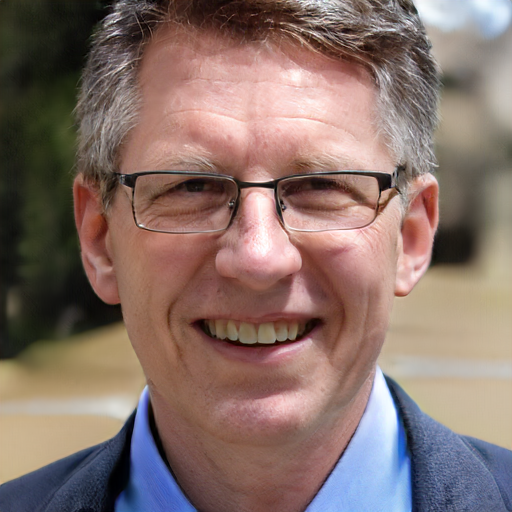

In [9]:
embedding_seed_5, img_5 = create_image(5)

img_5

In [10]:
!pip install transformers

In [11]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("image-classification",
                model="rizvandwiki/gender-classification",
                device=0)

2024-04-02 14:16:22.614847: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 14:16:22.614973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 14:16:22.933568: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

In [12]:
#run this and then extract features if you care about your bank balance
dataset = create_image_range(range(10_000))

100%|██████████| 10000/10000 [20:17<00:00,  8.21it/s]


In [14]:
latents = []
y = []
for latent, img in tqdm(dataset):
    latents.append(latent.squeeze(0).cpu())
     
    predictions = pipe(img)
    prediction = predictions[0]['label'] if predictions[0]['score'] > predictions[1]['score'] else predictions[1]['label']
    y.append(prediction)

100%|██████████| 10000/10000 [03:49<00:00, 43.52it/s]


In [15]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(latents, y, test_size=0.2, random_state=42)

svm = SVC(kernel='linear', C=1.0)
svm.fit(x_train, y_train)
print('Train accuracy: ', svm.score(x_train, y_train))
print('Validation accuracy: ', svm.score(x_val, y_val))

coef = np.array(svm.coef_).reshape(-1)
coef = coef / np.linalg.norm(coef)
coef = torch.tensor(coef, device='cuda:0')
torch.save(coef, 'gender_coef.pt')

Train accuracy:  0.829625
Validation accuracy:  0.778


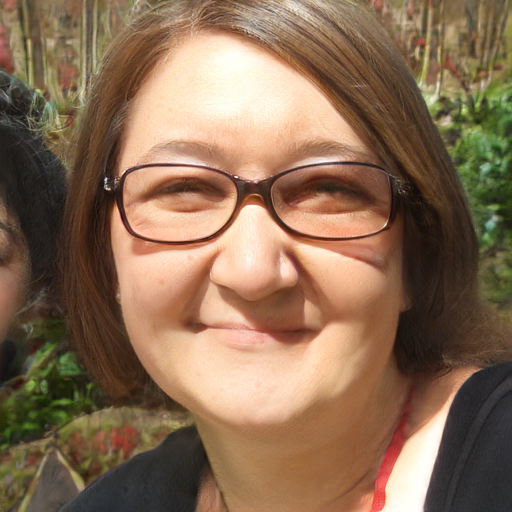

In [18]:
embedding_10, img_10 = create_image(10)

img_10

In [17]:
def linear_interpolate(code1, code2, alpha):
    return code1 + code2*alpha

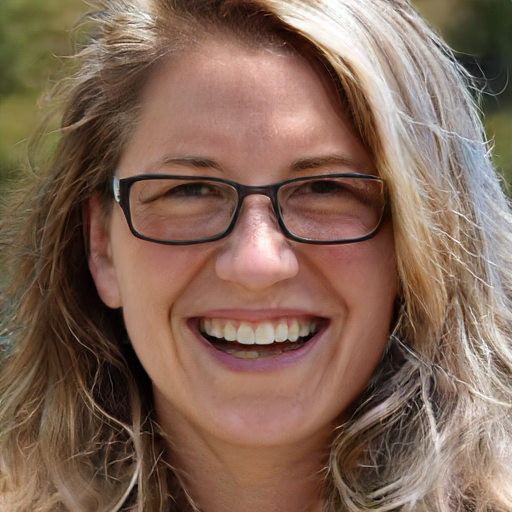

In [55]:
interpolated_embedding = linear_interpolate(embedding_seed_5, coef, -2)
gen_image_from_z(interpolated_embedding)

In [73]:
def make_interp_animation(from_img, to_img, num_steps, seed, sign=1, max_factor=6):
    step_size = max_factor/num_steps
    
    all_imgs = []
    
    amounts = np.arange(0, max_factor, step_size)
    
    for alpha in tqdm(amounts):
        interpolated_embedding = linear_interpolate(from_img, to_img, sign*alpha)
        image = gen_image_from_z(interpolated_embedding)
        all_imgs.append(image)
        
    save_name = f"out/latent_space_traversal_seed_{seed}.gif"
    all_imgs[0].save(save_name, save_all=True, append_images=all_imgs[1:], duration=1000/num_steps, loops=0)


In [69]:
test = make_interp_animation(embedding_seed_5, coef, 200, seed=5, sign=-1, max_factor=2)

100%|██████████| 200/200 [00:25<00:00,  7.96it/s]
